In [2]:
import json
import re

# --- Load and extract user messages from JSON ---
with open("conversations.json", "r", encoding="utf-8") as f:
    data = json.load(f)

user_messages = []
for convo in data:
    mapping = convo.get("mapping", {})
    for msg in mapping.values():
        message = msg.get("message")
        if not message:
            continue
        author = message.get("author", {})
        if author.get("role") == "user":
            parts = message.get("content", {}).get("parts", [])
            if parts and isinstance(parts[0], str):
                user_messages.append(parts[0])

# --- First-stage filter: short, duplicates, empty ---
filtered_messages = [
    msg for msg in set(user_messages)
    if len(msg.split()) >= 5 and re.search(r'\w', msg)
]

# --- Second-stage filter: noisy/loggy/cody lines ---
def is_good_line(line):
    if len(line) > 1000:
        return False
    if re.search(r"\$\s|^\(base\)|Traceback|File\s\"|\.py in <module>", line):
        return False
    if re.search(r"From:.*@.*\s|Subject:|^https?://", line):
        return False
    if re.search(r"(Caltech|NASA|Ureka|Ph\.D|Postdoctoral|Technical Skills|Experience)", line):
        return False
    if re.search(r"ValueError|matplotlib|pandas|ArrowInvalid", line, re.IGNORECASE):
        return False
    if re.match(r"^\(base\)|^\$|^ls\b|^git\b|^python\b", line):
        return False
    if re.search(r"\\cite|\{.*@.*\}|\bibliographystyle", line):
        return False
    if re.search(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+", line):
        return False
    return True

# --- Final cleanup ---
cleaned_lines = []
for line in filtered_messages:
    line = line.replace("\n", " ").strip()
    if not is_good_line(line):
        continue
    line = re.sub(r"\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}", "[REDACTED]", line)
    line = re.sub(r"\bShooby\b|\bShoubaneh\b", "[REDACTED]", line)
    cleaned_lines.append(line)

# --- Save final file ---
with open("shooby_final_prompts.txt", "w", encoding="utf-8") as f:
    for line in cleaned_lines:
        f.write(line + "\n")

print(f"✅ Total user messages extracted: {len(user_messages)}")
print(f"✅ After filtering: {len(filtered_messages)}")
print(f"✅ Final polished lines: {len(cleaned_lines)}")


✅ Total user messages extracted: 9111
✅ After filtering: 7699
✅ Final polished lines: 6099


In [4]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import pandas as pd
import ast

# Load prompts
with open("shooby_final_prompts.txt", "r", encoding="utf-8") as f:
    prompts = [line.strip() for line in f if len(line.strip()) > 5]

# Load sentence transformer
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(prompts)

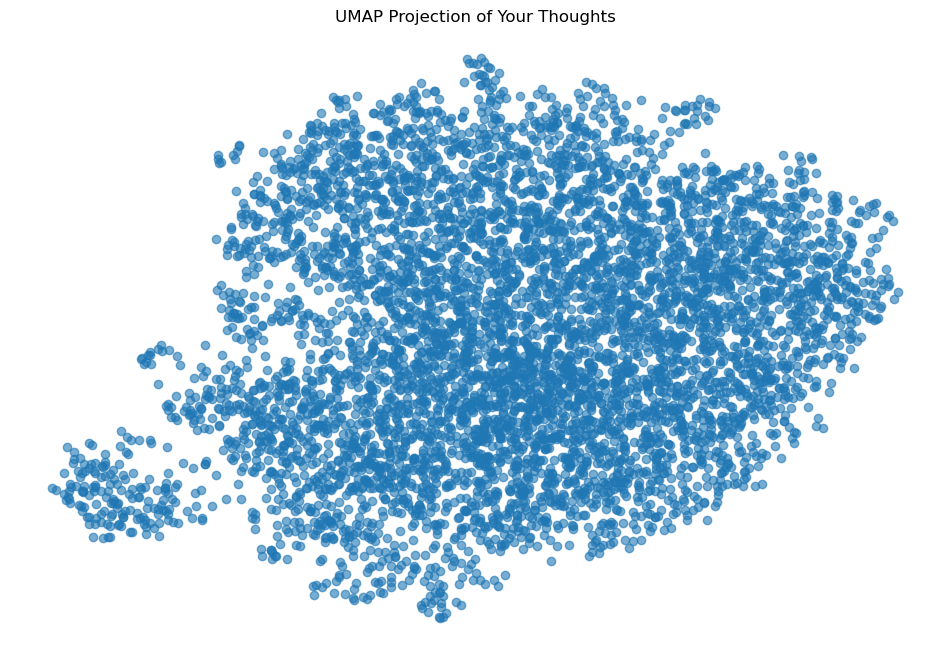

In [18]:
# Reduce dimensions
reducer = umap.UMAP(n_neighbors=10, min_dist=0.9, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

# Visualize
df = pd.DataFrame(embedding_2d, columns=["x", "y"])
df["prompt"] = prompts

plt.figure(figsize=(12, 8))
plt.scatter(df["x"], df["y"], alpha=0.6)
plt.title("UMAP Projection of Your Thoughts")
plt.axis('off')
plt.grid(True)
plt.show()


In [20]:
import plotly.express as px
import pandas as pd
from sklearn.cluster import KMeans

# KMeans clustering
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=32)
labels = kmeans.fit_predict(embedding_2d)

# DataFrame
df_vis = pd.DataFrame(embedding_2d, columns=["UMAP 1", "UMAP 2"])
df_vis["message"] = prompts
df_vis["cluster"] = labels.astype(str)

# Moody glowing palette (deep, luminous tones)
neo_expressionist_palette = [
    "#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0",  # magenta → cyan
    "#FFB703", "#FB8500", "#E63946", "#9A031E", "#5F0F40",  # hot yellows → red
    "#06D6A0", "#118AB2", "#073B4C", "#FFD6A5", "#FFADAD",  # cool aquas and pastels
    "#CDB4DB", "#FFAFCC", "#BDE0FE", "#A2D2FF", "#D9ED92"   # pale pastels
]

# Plot
fig = px.scatter(
    df_vis,
    x="UMAP 1",
    y="UMAP 2",
    color="cluster",
    custom_data=["message"],
    color_discrete_sequence=neo_expressionist_palette,
    title="🌌 ShoobAI: UMAP of Thoughts",
    opacity=0.8,
    height=800
)

fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>",
    marker=dict(size=6)
)

fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=24),
    showlegend=False
)
import plotly.io as pio
pio.renderers.default = "browser"
fig.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
from keybert import KeyBERT
import json
import re
from tqdm import tqdm

# Load data
with open("conversations.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract assistant messages
assistant_messages = []
for convo in data:
    mapping = convo.get("mapping", {})
    for msg in mapping.values():
        message = msg.get("message")
        if not message:
            continue
        author = message.get("author", {})
        if author.get("role") == "assistant":
            parts = message.get("content", {}).get("parts", [])
            if parts and isinstance(parts[0], str):
                text = parts[0]
                if (
                    len(text.split()) >= 5
                    and len(text) <= 1000
                    and not re.search(r"(Traceback|File\s\"|ValueError|NameError|ModuleNotFound)", text)
                ):
                    assistant_messages.append(text)

print(f"✅ Total messages to summarize: {len(assistant_messages)}")

# Use KeyBERT to extract short summaries (keywords/phrases)
kw_model = KeyBERT("all-MiniLM-L6-v2")

summaries = []
for msg in assistant_messages:
    keywords = kw_model.extract_keywords(msg, keyphrase_ngram_range=(1, 3), stop_words="english", top_n=1)
    if keywords:
        summaries.append(keywords[0][0])
    else:
        summaries.append("misc")

# Save summaries
with open("shooby_assistant_summaries.txt", "w", encoding="utf-8") as f:
    for s in summaries:
        f.write(s.strip() + "\n")

print(f"✅ Done! Saved {len(summaries)} one-liners to shooby_assistant_summaries.txt")


✅ Total messages to summarize: 3937
✅ Done! Saved 3937 one-liners to shooby_assistant_summaries.txt


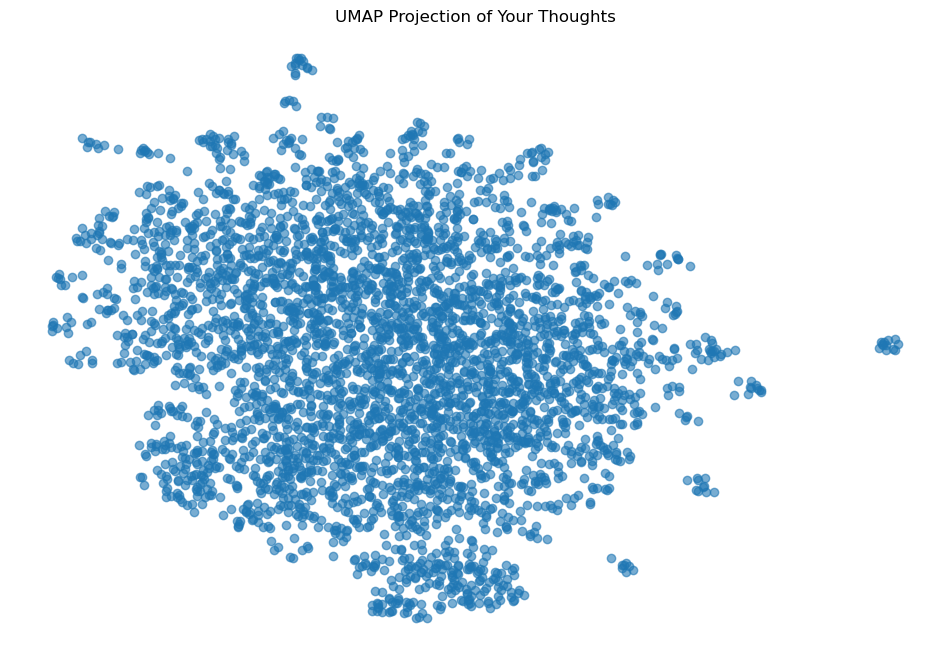

In [39]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import pandas as pd
import ast

# Load prompts
with open("shooby_assistant_summaries.txt", "r", encoding="utf-8") as f:
    prompts = [line.strip() for line in f if len(line.strip()) > 5]

# Load sentence transformer
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(prompts)

# Reduce dimensions
reducer = umap.UMAP(n_neighbors=10, min_dist=0.9, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

# Visualize
df = pd.DataFrame(embedding_2d, columns=["x", "y"])
df["prompt"] = prompts

plt.figure(figsize=(12, 8))
plt.scatter(df["x"], df["y"], alpha=0.6)
plt.title("UMAP Projection of Your Thoughts")
plt.axis('off')
plt.grid(True)
plt.show()